In [1]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#  Importing libraries

In [2]:
# importing the required libraries

import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from skimage.transform import resize
from PIL import Image
from keras.preprocessing import image

%matplotlib inline

# Analyzing Dataset

In [3]:
# checking the directory 
plants_dir = "/content/drive/MyDrive/Plant-seedlings-classification"

In [4]:
# checking the list in the directory
os.listdir(plants_dir)

['test', 'train', 'sample_submission.csv']

In [124]:
# setting the test path and train path
test_path = plants_dir+'/Prediction/'
train_path = plants_dir+'/train/'

In [6]:
# checking the categories 
categories = os.listdir(train_path)
categories

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [7]:
# checking the number of train images
total_train_images = 0

for i in categories:
  print("No. of images for category " + i + " : " + str(len(os.listdir(train_path+  i ))))
  total_train_images += len(os.listdir(train_path+  i ))
print("Total - " + str(total_train_images))

No. of images for category Black-grass : 263
No. of images for category Charlock : 390
No. of images for category Cleavers : 287
No. of images for category Common Chickweed : 611
No. of images for category Common wheat : 221
No. of images for category Fat Hen : 475
No. of images for category Loose Silky-bent : 654
No. of images for category Maize : 221
No. of images for category Scentless Mayweed : 517
No. of images for category Shepherds Purse : 231
No. of images for category Small-flowered Cranesbill : 497
No. of images for category Sugar beet : 385
Total - 4752


In [8]:
# checking the number of test images
len(os.listdir(test_path))

794

In [9]:
# Test dataset mean image size
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path):
  img = plt.imread(test_path+'/'+image_filename)
  d1,d2,colors = img.shape
  dim1.append(d1)
  dim2.append(d2)

print(np.mean(dim1), ' * ', np.mean(dim2))

269.492443324937  *  269.492443324937


In [10]:
# Train dataset mean image size
for plant_type in os.listdir(train_path):
  dim1 = []
  dim2 = []
  print(plant_type)
  for image_filename in os.listdir(train_path+'/'+plant_type):
    img = plt.imread(train_path+'/'+plant_type+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)
  print(np.mean(dim1), ' * ', np.mean(dim2))

Black-grass
661.3079847908746  *  668.638783269962
Charlock
431.9769230769231  *  431.98205128205126
Cleavers
310.2926829268293  *  310.2926829268293
Common Chickweed
230.708674304419  *  230.708674304419
Common wheat
440.1674208144796  *  440.17194570135746
Fat Hen
303.0084210526316  *  303.0084210526316
Loose Silky-bent
397.8975535168196  *  399.5963302752294
Maize
483.23981900452486  *  483.2533936651584
Scentless Mayweed
225.95164410058027  *  225.95164410058027
Shepherds Purse
288.54112554112555  *  288.54112554112555
Small-flowered Cranesbill
341.87726358148893  *  341.87726358148893
Sugar beet
590.3090909090909  *  591.4779220779221


# Image Visualization

In [11]:
train_data = []
for category_id, category in enumerate(categories):
    for file in os.listdir(os.path.join(train_path, category)):
        train_data.append(['{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train_data, columns=['imagefile', 'category_id', 'category'])

In [12]:
train.sample(6)

imagefile  category_id          category
417           Charlock/6ea9a8d71.png            1          Charlock
50         Black-grass/32d97b170.png            0       Black-grass
2056           Fat Hen/9f4788348.png            5           Fat Hen
1016  Common Chickweed/168fed6c3.png            3  Common Chickweed
2600  Loose Silky-bent/88a48f427.png            6  Loose Silky-bent
2813  Loose Silky-bent/db5bc3276.png            6  Loose Silky-bent

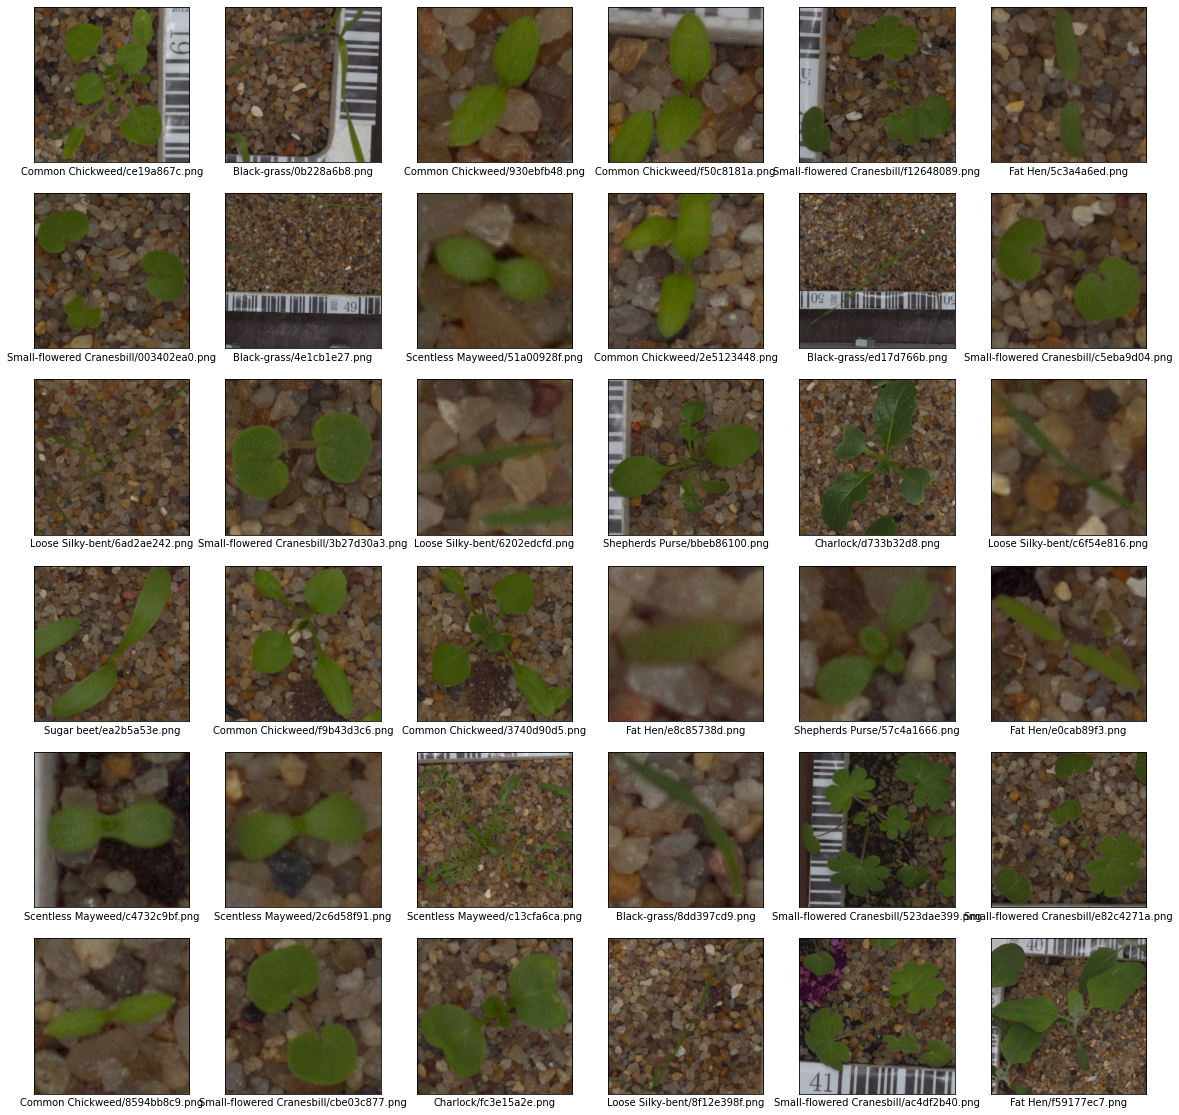

In [13]:
# visualizing few training images
plt.figure(figsize=(20,20))
for i in range(36):
  idx = random.randint(0, 4751)
  plt.subplot(6,6,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(plt.imread(train_path + train['imagefile'][idx]))
  plt.xlabel(train['imagefile'][idx])
plt.show()

# Training with SVM

In [14]:
# creating the features from the images
def create_features(img):
    # flatten three channel color image
    color_features = img[...,:3].flatten()
    # convert image to greyscale
    grey_image = np.dot(img[...,:3], [0.299, 0.587, 0.114])
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack((color_features,hog_features))
    return flat_features

In [15]:
# flattening the image to 1D
flat_data = []
target = []
for ind in train.index:
  path = train_path +   train['imagefile'][ind]
  img = Image.open(path)
  img_resized = img.resize((64,64))
  img_resized_array = np.array(img_resized)
  flat_data.append(create_features(img_resized_array))
  target.append(train['category'][ind])
flat_data = np.array(flat_data)
target = np.array(target)

In [16]:
# dataframe with the resized images array
df_resized_images = pd.DataFrame(flat_data.tolist())

In [17]:
# shape of the dataset
df_resized_images.shape

(4752, 12612)

In [18]:
df_resized_images.sample(5)

0      1      2      3      ...     12608     12609     12610     12611
1365   79.0   50.0   25.0   81.0  ...  0.095394  0.102499  0.105536  0.092822
3271   59.0   43.0   29.0   65.0  ...  0.152777  0.097972  0.069214  0.021895
4473  161.0  159.0  159.0  158.0  ...  0.086038  0.080576  0.047962  0.091538
499    92.0   70.0   59.0   82.0  ...  0.109367  0.178072  0.108766  0.142053
2340   72.0   39.0   21.0   73.0  ...  0.082836  0.126937  0.062841  0.108490

[5 rows x 12612 columns]

In [19]:
# checking for null 
df_resized_images.isna().sum().sum()

0

In [20]:
# normalizing the dataset
sc = StandardScaler()

In [21]:
df_scaled = sc.fit_transform(df_resized_images)

In [22]:
#applying PCA to get the most relevant features 
pca = PCA(n_components=500)

In [23]:
df_pca = pd.DataFrame(pca.fit_transform(df_scaled))

In [24]:
# splitting the dataset to train and test
X = pd.DataFrame(df_pca)
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=7)

In [25]:
# define support vector classifier
svc_model = SVC(C= 10, kernel='linear', gamma= 1, random_state=7, probability=True)

# fit model
svc_model.fit(X_train, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=True, random_state=7, shrinking=True, tol=0.001,
    verbose=False)

In [28]:
# cross val scores
scores = cross_val_score(svc_model, X_train, y_train, cv=4, scoring='accuracy')
np.mean(scores) 

0.480398472521999

# Image generator

In [29]:
#setting the image datagenerator model
image_size = 64
batch_size = 32

image_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)

In [30]:
#Build training generator
train_generator = image_datagenerator.flow_from_directory('/content/drive/MyDrive/Plant-seedlings-classification/train/',
                                                    target_size=(image_size, image_size),
                                                    subset='training',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed= 7
                                                )

#Build validation generator
val_generator = image_datagenerator.flow_from_directory('/content/drive/MyDrive/Plant-seedlings-classification/train/',
                                                   target_size=(image_size, image_size),                                                   
                                                   subset='validation',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   seed= 7
                                                )

Found 3805 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [31]:
#Lets check the features (images) and Labels (plant class) returned by ImageDataGenerator
X, y = next(train_generator)

print('Input features shape', X.shape)
print('Actual labels shape', y.shape)

Input features shape (32, 64, 64, 3)
Actual labels shape (32, 12)


# Training with Neural Networks

In [41]:
#Clear any previous model from memory
tf.keras.backend.clear_session()

#Initialize model
model = tf.keras.models.Sequential()

#flatten the layers
model.add(tf.keras.layers.Flatten(input_shape=(image_size,image_size,3)))
# normalizing the features
model.add(tf.keras.layers.BatchNormalization())

# adding layer
model.add(tf.keras.layers.Dense(128, activation='relu'))

# adding layer
model.add(tf.keras.layers.Dense(128, activation='relu'))
# normalizing the features
model.add(tf.keras.layers.BatchNormalization())

# adding layer
model.add(tf.keras.layers.Dense(64, activation='relu'))
# adding dropout
model.add(tf.keras.layers.Dropout(0.20))

# adding layer
model.add(tf.keras.layers.Dense(32, activation='relu'))
# normalizing the features
model.add(tf.keras.layers.BatchNormalization())

# adding layer
model.add(tf.keras.layers.Dense(32, activation='relu'))

# adding output layer
model.add(tf.keras.layers.Dense(12, activation='softmax'))

In [42]:
#Specify Loss and Optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12288)             49152     
_________________________________________________________________
dense (Dense)                (None, 128)               1572992   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [43]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('plant_seedings_DNN.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1)

In [44]:
model.fit(train_generator,
                    epochs=30,
                    steps_per_epoch= 3805//batch_size,  #Number of training images//batch_size
                    validation_data=val_generator,
                    validation_steps = 947//batch_size, #Number of test images//batch_size
                    callbacks = [model_checkpoint])

Epoch 1/30
118/118 [==============================] - 61s 515ms/step - loss: 2.5843 - accuracy: 0.1234 - val_loss: 2.7772 - val_accuracy: 0.1239

Epoch 00001: val_accuracy improved from -inf to 0.12392, saving model to plant_seedings.h5
Epoch 2/30
118/118 [==============================] - 61s 521ms/step - loss: 2.2499 - accuracy: 0.2163 - val_loss: 2.1029 - val_accuracy: 0.2468

Epoch 00002: val_accuracy improved from 0.12392 to 0.24677, saving model to plant_seedings.h5
Epoch 3/30
118/118 [==============================] - 59s 501ms/step - loss: 2.0380 - accuracy: 0.2765 - val_loss: 1.8738 - val_accuracy: 0.3254

Epoch 00003: val_accuracy improved from 0.24677 to 0.32543, saving model to plant_seedings.h5
Epoch 4/30
118/118 [==============================] - 60s 505ms/step - loss: 1.9041 - accuracy: 0.3003 - val_loss: 1.7992 - val_accuracy: 0.3470

Epoch 00004: val_accuracy improved from 0.32543 to 0.34698, saving model to plant_seedings.h5
Epoch 5/30
118/118 [=======================

In [45]:
# loading the model saved with the best acccuracy
model_DNN = tf.keras.models.load_model('/content/plant_seedings_DNN.h5')

In [51]:
_ , acc = model_DNN.evaluate(val_generator, steps=len(val_generator))
print("Accuracy", acc)

30/30 [==============================] - 12s 401ms/step - loss: 1.4201 - accuracy: 0.5069
Accuracy 0.5068637728691101


# Training with CNN

In [134]:
#Clear any previous model from memory
tf.keras.backend.clear_session()

#Initialize model
model = tf.keras.models.Sequential()

#Add Conv Layer
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), input_shape=(image_size, image_size, 3), activation='relu'))

#Add Conv Layer
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization())

#Add Max Pool layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#Add Conv Layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization())

#Add Max Pool layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#Add Conv Layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization())

#Add Max Pool layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#Add Global Max Pool layer
model.add(tf.keras.layers.GlobalMaxPool2D())

#Flatten the data
model.add(tf.keras.layers.Flatten())

#Add 1st dense layer
model.add(tf.keras.layers.Dense(64, activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization())

#Add Dropout
model.add(tf.keras.layers.Dropout(0.3))

#Add 2nd dense layer
model.add(tf.keras.layers.Dense(64, activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization())

#Add Dropout
model.add(tf.keras.layers.Dropout(0.3))

#Add Output Layer
model.add(tf.keras.layers.Dense(12, activation='softmax'))

In [135]:
#Specify Loss and Optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0

In [136]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('plant_seedings_CNN.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1)

In [137]:
model.fit(train_generator,
                    epochs=30,
                    steps_per_epoch= 3805//batch_size,  #Number of training images//batch_size
                    validation_data=val_generator,
                    validation_steps = 947//batch_size, #Number of test images//batch_size
                    callbacks = [model_checkpoint])

Epoch 1/30
118/118 [==============================] - 63s 520ms/step - loss: 2.9215 - accuracy: 0.1392 - val_loss: 2.1906 - val_accuracy: 0.2931

Epoch 00001: val_accuracy improved from -inf to 0.29310, saving model to plant_seedings_CNN.h5
Epoch 2/30
118/118 [==============================] - 61s 519ms/step - loss: 1.8771 - accuracy: 0.3829 - val_loss: 1.6249 - val_accuracy: 0.4515

Epoch 00002: val_accuracy improved from 0.29310 to 0.45151, saving model to plant_seedings_CNN.h5
Epoch 3/30
118/118 [==============================] - 61s 514ms/step - loss: 1.5018 - accuracy: 0.4841 - val_loss: 1.2046 - val_accuracy: 0.6056

Epoch 00003: val_accuracy improved from 0.45151 to 0.60560, saving model to plant_seedings_CNN.h5
Epoch 4/30
118/118 [==============================] - 62s 521ms/step - loss: 1.2806 - accuracy: 0.5744 - val_loss: 1.7690 - val_accuracy: 0.4375

Epoch 00004: val_accuracy did not improve from 0.60560
Epoch 5/30
118/118 [==============================] - 60s 509ms/step -

In [138]:
# loading the model saved with the best acccuracy
model_CNN = tf.keras.models.load_model('/content/plant_seedings_CNN.h5')

In [139]:
_ , acc = model_CNN.evaluate(val_generator, steps=len(val_generator))
print("Accuracy", acc)

30/30 [==============================] - 12s 396ms/step - loss: 0.4190 - accuracy: 0.8659
Accuracy 0.8658922910690308


# Comparing the accuracy results from three trained models


1. Supervised learning model
    * Used SVM model to train the data and validate the results
    * All the images are set to 64* 64 and then flattened to 1-D to fit into model
    * Obtained an **accuracy score of 48.04%**

2. Neural Network
    * Image generator has been used here to load the images.
    * All the images are set to 64* 64 and then flattened prior to passing the data to first dense layer
    * Obtained an **accuracy score of 50.69%**
    * Model improved with Neural Network

3. Convolutions Neural Network
    * Image generator has been used here to load the images.
    * All the images are set to 64 * 64 
    * Obtained an **accuracy score of 86.59%**
    * Model improved a lot with convolutional Neural Network model

Model build on the CNN can be used for predicting the test images

# Prediction

In [125]:
# Read all test data from the prediction(test) folder
test_data = []
for file in os.listdir(test_path):
    test_data.append([file])
final_test_data = pd.DataFrame(test_data, columns=['imagefile'])

In [140]:
# storing the indices to assign after prediction(predict proba)
plants_labels ={'Black-grass': 0,
                      'Charlock': 1,
                      'Cleavers': 2,
                      'Common Chickweed': 3,
                      'Common wheat': 4,
                      'Fat Hen': 5,
                      'Loose Silky-bent': 6,
                      'Maize': 7,
                      'Scentless Mayweed': 8,
                      'Shepherds Purse': 9,
                      'Small-flowered Cranesbill': 10,
                      'Sugar beet': 11}
plants_labels

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [141]:
# method to classify the test images
def plant_seeds_classifier():
    # getting the testing images
    test_generator = image_datagenerator.flow_from_dataframe(dataframe=final_test_data,
                                                        directory=test_path,
                                                        x_col="imagefile",
                                                        y_col=None,
                                                        batch_size=1,
                                                        shuffle=False,
                                                        class_mode=None,
                                                        target_size=(66, 66),
                                                        color_mode='rgb');
        
    filenames = test_generator.filenames
    nb_samples = len(filenames)
    # getting the predictions
    predictions = model_CNN.predict(test_generator,steps = nb_samples) 
    predicted_class_indices=np.argmax(predictions,axis=1)
    labels = dict((v,k) for k,v in plants_labels.items())
    predicted_labels = [labels[k] for k in predicted_class_indices]
    results=pd.DataFrame({"file":filenames,
                          "species":predicted_labels})
    # returning the predicted dataframe
    return results

In [142]:
predictions_labels = plant_seeds_classifier()

Found 794 validated image filenames.


In [143]:
predictions_labels

file                    species
0    003d61042.png                    Fat Hen
1    0021e90e4.png  Small-flowered Cranesbill
2    007b3da8b.png                 Sugar beet
3    0086a6340.png           Common Chickweed
4    00c47e980.png                 Sugar beet
..             ...                        ...
789  fea355851.png           Loose Silky-bent
790  fea3da57c.png                 Sugar beet
791  fef2ade8c.png                 Sugar beet
792  ff65bc002.png                   Charlock
793  ffc6f8527.png               Common wheat

[794 rows x 2 columns]

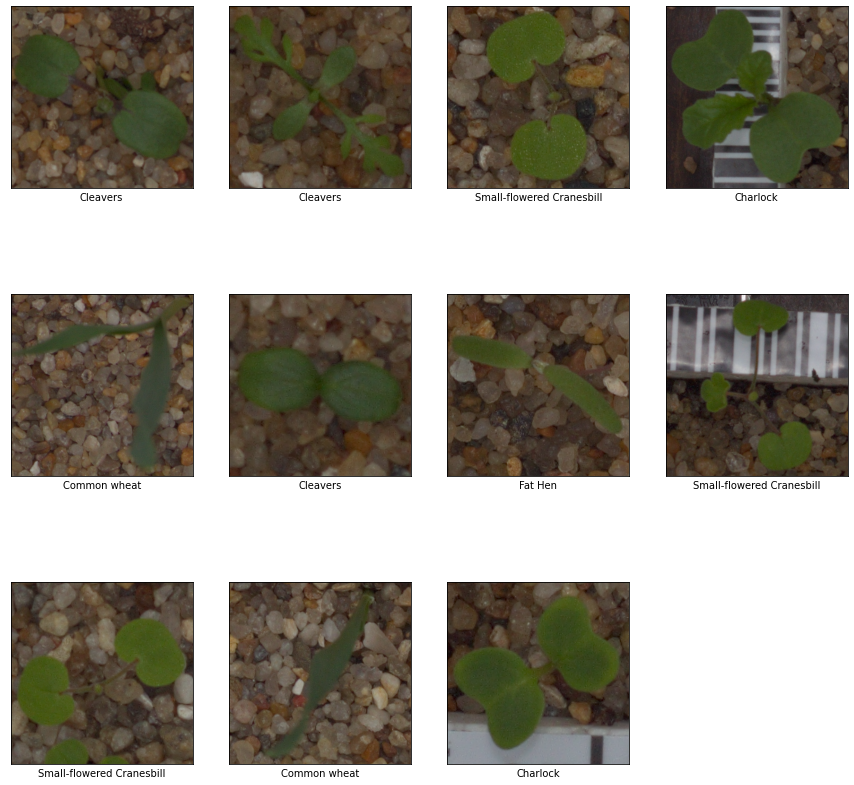

In [145]:
# visualizing few test images and the predicted plant species labels
plt.figure(figsize=(15,15))
for i in range(11):
  idx = random.randint(0, 793)
  plt.subplot(3,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(plt.imread(test_path + predictions_labels['file'][idx]))
  plt.xlabel(predictions_labels['species'][idx])
plt.show()



* From the above models trained and tested the CNN has outperformed other two models 
    * The images are passed as is and with the help of filters the CNN model is able to learn in detail.
    * As it gathers the spatial information, it can learn the feature in more detail like the edges, shape etc.
    * In each iteration the weights applied or learning it gets enbles it to  gather more information about the feture it already learnt in the previous iteration.
* Neural networks outperforms the SVM 
    * Feature extraction is done internally by the model and it identifies the classes more efficiently.
    * SVM we had to extract the features and get it with PCA and then was able to build the model.
    * Even though there are plenty of fetureas and iterations the model buidling is faster and more efficient.
    



# Building image dataset for Cars

In [ ]:
# Manually created the folders for the images in the drive path

In [152]:
# checking the directory 
car_train_path = '/content/drive/MyDrive/Cars/Train/'
car_test_path = '/content/drive/MyDrive/Cars/Test/'

In [155]:
# checking the list of categories
car_categories = os.listdir(car_train_path)
car_categories

['Acura',
 'Audi',
 'Buick',
 'Chevrolet',
 'Dodge',
 'Hyundai',
 'Mistibuishi',
 'Toyota']

In [153]:
# checking the number of test images
len(os.listdir(car_test_path))

5

In [159]:
train_car_data = []
for category_id, category in enumerate(car_categories):
    for file in os.listdir(os.path.join(car_train_path, category)):
        train_car_data.append(['{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train_car_data, columns=['imagefile', 'category_id', 'category'])

In [160]:
train

imagefile  category_id     category
0        Acura/00002.jpg            0        Acura
1         Audi/00001.jpg            1         Audi
2        Buick/00011.jpg            2        Buick
3    Chevrolet/00010.jpg            3    Chevrolet
4        Dodge/00007.jpg            4        Dodge
5        Dodge/00008.jpg            4        Dodge
6      Hyundai/00004.jpg            5      Hyundai
7  Mistibuishi/00009.jpg            6  Mistibuishi
8       Toyota/00013.jpg            7       Toyota
9       Toyota/00012.jpg            7       Toyota

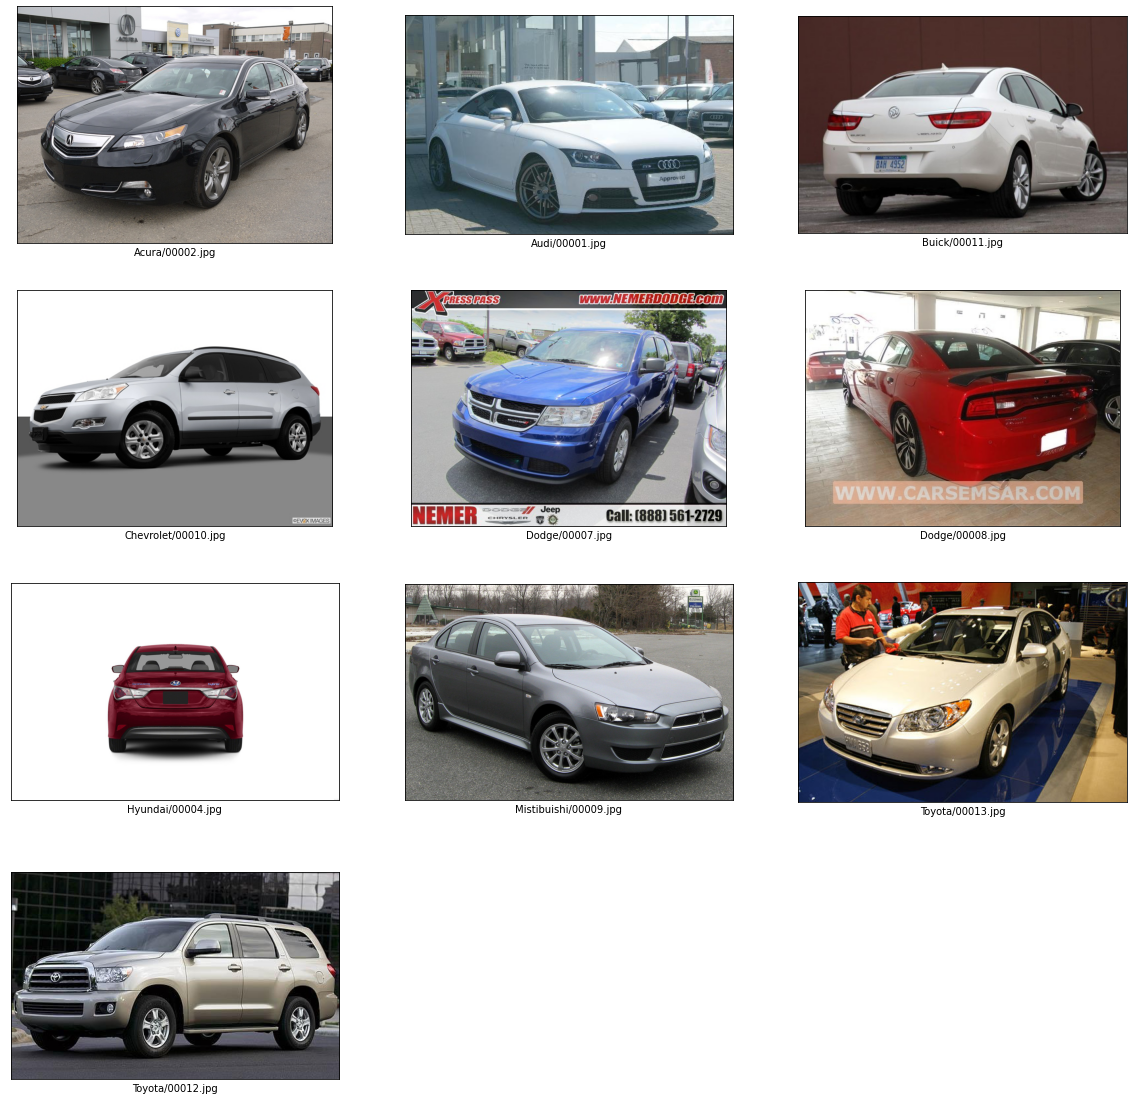

In [169]:
# displayin all the training images with the brand and file name
plt.figure(figsize=(20,20))
for i in range(10):
  plt.subplot(4,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(plt.imread(car_train_path + train['imagefile'][i]))
  plt.xlabel(train['imagefile'][i])
plt.show()

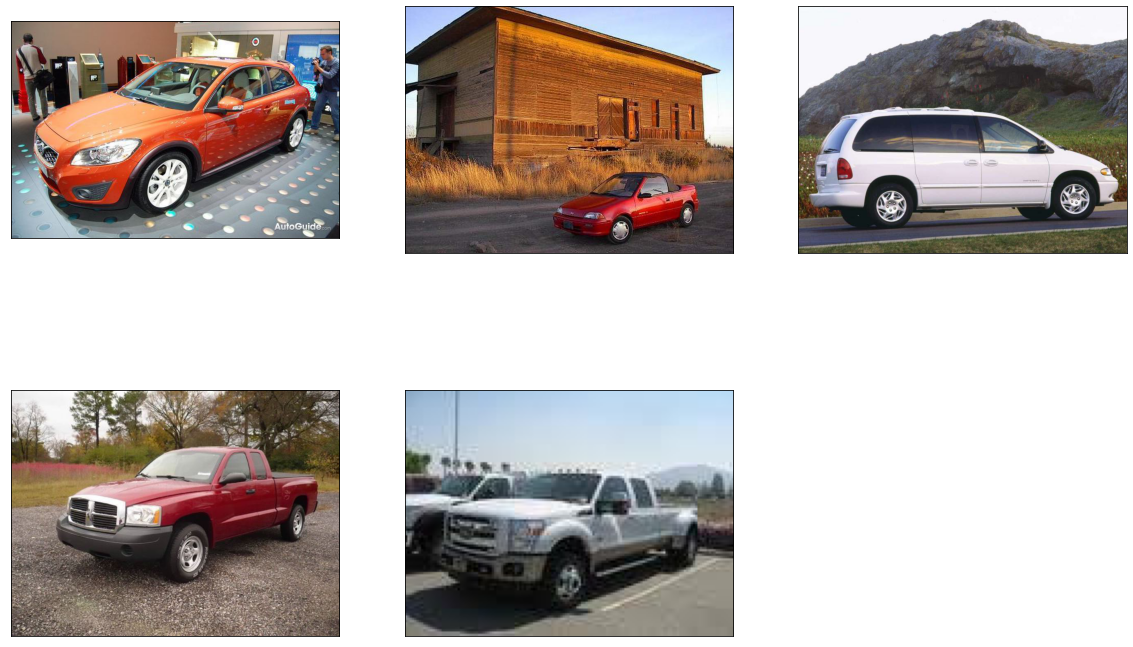

In [183]:
# displaying all the testing images with the brand and file name
plt.figure(figsize=(20,20))
i = 1
for file in os.listdir(car_test_path):
  plt.subplot(3,3,i)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(plt.imread(car_test_path + file))
  i = i+1
plt.show()

Challenges faced

* Main challenge involved was the manual creation of the folders 
  * First had to open each image and identify the brand/make of the car
  * Had to see the logo to check and identify and certain ones had to research and find out
  * Folder was created based on each labels (brand) and then had to add each file to the corresponding folder
  * The car images that could not be identified had to be put into the test folder inorder to get the help from the machine to predict the brand.

